# Casino HMM: Inference (state estimation)

We use a simple example of an HMM known as the "occasionally dishonest casino".
This is from the book:

> "Biological Sequence Analysis: Probabilistic Models of Proteins and Nucleic Acids" by R. Durbin, S. Eddy, A. Krogh and G. Mitchison (1998).

Imagine you are playing dice at a shady casino -- an Old West saloon, perhaps. You suspect that one of the players is cheating. Most of the time, they use a standard die in which all six faces are equally probable, but every so often they secretly switch to a weighted die that comes up 6 half the time. To avoid getting caught, they don't switch dice very often: once they switch, they tend to keep using the same die for a while. 

<p align="center">
  <img src="https://github.com/probml/dynamax/blob/main/docs/figures/casino.png?raw=true">
</p>

The figure above formalizes this game. If the player is rolling the fair die, they continue to do so with 0.95 probability, but they switch to the loaded die with probability 0.05. They continue using the loaded die with probability 0.9, and switch back to the fair die with probability 0.1. 

**Can you infer which die the player is using on the basis of the outcomes alone?**  We'll show how using a categorical hidden Markov model (HMM) and the `CategoricalHMM` class.


## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap
from jax.nn import one_hot

from dynamax.hidden_markov_model import CategoricalHMM

## Make a Categorical HMM

First, we'll construct a categorical hidden Markov model (HMM). The model has discrete latent states $z_t \in \{1,2\}$ to specify which of the two dice is used on the $t$-th roll. You observe the outcomes, or "emissions," $y_t \in \{1,\ldots,6\}$. The categorical HMM specifies a joint distribution over the latent states and emissions,

\begin{align}
p(y_{1:T}, z_{1:T} \mid \theta) 
&= \mathrm{Cat}(z_1 \mid \pi) 
\prod_{t=2}^T \mathrm{Cat}(z_t \mid A_{z_{t-1}}) 
\prod_{t=1}^T \mathrm{Cat}(y_t \mid B_{z_t})
\end{align}

It's called a _categorical_ HMM because the emissions $y_t$ follow a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution), which we denote by $\mathrm{Cat}$. The parameters $\theta = (\pi, A, B)$ consist of the _initial distribution_ $\pi$, the _transition matrix_ $A$, and the _emission probabilities_ $B$. The notation $A_{z_t}$ denotes the $z_t$-th row of the matrix $A$, which is a vector of length 2 specifying the distribution over the next state, $z_{t+1}$. Likewise, $B_{z_t}$ denotes the $z_t$-th row of the matrix $B$, which is a vector of length 6 specifying the distribution over outcomes for the corresponding die.

In this example, we assume we know all of these parameters. Let's start by instantiating them in code.

In [3]:
initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.95, 0.05], 
                               [0.10, 0.90]])
emission_probs = jnp.array([[1/6,  1/6,  1/6,  1/6,  1/6,  1/6],    # fair die
                            [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]])  # loaded die

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: (2, 2)
B.shape: (2, 6)


The `CategoricalHMM` object implements a categorical hidden Markov model. This object actually allows for a more general situation in which you observe many conditionally independent categorical emissions at once. This can lead to a little confusion, so we'll go into some detail on this point. 

In this example, $z_t$ can take on two values. We call this the _number of states_, and it corresponds to the number of different types of dice the player rolls. In a more general scenario, you could imagine the player rolling multiple dice at once. We call the number of simultaneously rolled dice the _number of emissions_. Finally, we call the number of possible outcomes (i.e. number of faces on each die) the _number of classes_. 

The code below constructs a `CategoricalHMM` and uses its `initialize` function to create a structure called `params`, which combines the parameters of the model in a format that the model needs for downstream analysis.

```{warning}
Since the model allows for arbitrary numbers of emissions (again, think number of simultaneously rolled dice), we need to reshape the emission probs to be (num_states x num_emissions x num_classes).
```

In [4]:
num_states = 2      # two types of dice (fair and loaded)
num_emissions = 1   # only one die is rolled at a time
num_classes = 6     # each die has six faces

# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(initial_probs=initial_probs,
                           transition_matrix=transition_matrix,
                           emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes))

`params` organizes the model parameters in the specific way that `CategoricalHMM` expects. Technically, its a [`NamedTuple`](https://docs.python.org/3/library/typing.html#typing.NamedTuple). You can print the params to see how they're organized, but they aren't really meant for human consumption.

In [5]:
print(params)

ParamsCategoricalHMM(initial=ParamsStandardHMMInitialState(probs=DeviceArray([0.5, 0.5], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=DeviceArray([[0.95, 0.05],
             [0.1 , 0.9 ]], dtype=float32)), emissions=ParamsCategoricalHMMEmissions(probs=DeviceArray([[[0.16666667, 0.16666667, 0.16666667, 0.16666667,
               0.16666667, 0.16666667]],

             [[0.1       , 0.1       , 0.1       , 0.1       ,
               0.1       , 0.5       ]]], dtype=float32)))


```{important}
The parameters are _immutable_, which means you can't directly edit them, as illustrated below. This is by design: JAX prefers immutable datatypes. (If you're new to JAX, please see [Thinking in JAX](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html).) Instead, use the `initialize` function to create structures with desired values. 
```

In [6]:
try:
    params.initial.probs = jnp.array([0.75, 0.25])
except Exception as e:
    print("Caught exception:", e)

Caught exception: can't set attribute


```{note}
You may have observed that `initialize` actually returns two things: a structure of parameters and a corresponding structure that specifies their properties. The latter is necesary for model fitting. We won't use them here, but we will in the next notebook!
```

## Sample data from model

Now that we've initialized the model parameters, we can use them to draw samples from the HMM. The `hmm.sample()` function takes in the parameters, a JAX pseudorandom number generator (see [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#random-numbers)), and a number of time steps to sample.

In [7]:
num_timesteps = 300
true_states, emissions = hmm.sample(params, jr.PRNGKey(42), num_timesteps)

print(f"true_states.shape: {true_states.shape}")
print(f"emissions.shape: {emissions.shape}")
print("")
print("First few states:    ", true_states[:5])
print("First few emissions: ", emissions[:5, 0])

true_states.shape: (300,)
emissions.shape: (300, 1)

First few states:     [1 1 1 1 1]
First few emissions:  [5 0 5 5 5]


```{warning}
The emissions have a last dimension of 1 since `num_emissions` is 1 in this example. If we rolled multiple dice simultaneously, the emisions shape would be `num_timesteps x num_emissions`.
```

### Vectorizing computation
JAX offers powerful tools for vectorizing and parallelizing computation. For example, we can use [vmap](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#auto-vectorization-with-vmap) to sample many sequences at once. 

In [8]:
# To sample multiple sequences, just use vmap
num_batches = 5

batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(0), num_batches))

print(f"batch_states.shape: {batch_states.shape}")
print(f"batch_emissions.shape: {batch_emissions.shape}")

batch_states.shape: (5, 300)
batch_emissions.shape: (5, 300, 1)


Let's plot a sequence of emissions and color-code them by the latent state (fair vs loaded). As expected, the loaded die comes up six much more often than the fair die. 

In [9]:
def plot_sequence(states, emissions):
    plt.imshow(one_hot(emissions[:, 0], 6).T, 
               aspect="auto", interpolation="none", cmap="Greys")
    plt.imshow(states[None, :], extent=(0, num_timesteps, num_classes-.5, -.5), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.xlabel("time")
    plt.ylabel("emission")
    plt.yticks(jnp.arange(6), jnp.arange(6) + 1)    # b/c python is zero indexed!
    plt.title("sampled sequence (white=fair, gray=loaded)")

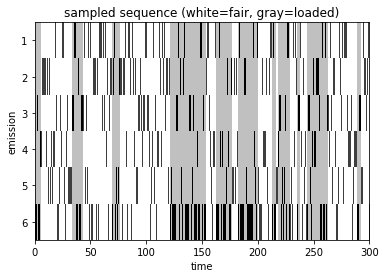

In [10]:
plot_sequence(batch_states[0], batch_emissions[0])

The difference in outcomes is borne out in the empirical frequencies of seeing a six in each state.

In [11]:
# count fraction of times we see 6 in each state
# remember that python is zero-indexed, so we have to add one!
p0 = jnp.mean(emissions[true_states==0] + 1 == 6)   # fair
p1 = jnp.mean(emissions[true_states==1] + 1 == 6)   # loaded
print("empirical frequencies: ", jnp.array([p0, p1]))
print("expected frequencies:  ", emission_probs[:, -1])

empirical frequencies:  [0.14970061 0.46616542]
expected frequencies:   [0.16666667 0.5       ]


## Filtering (forwards algorithm)

In an HMM, _filtering_ means computing the probabilities of the latent state at time $t$ given emissions up to and including time $t$. Mathematically, the filtering distributions are,
\begin{align}
p(z_t \mid y_{1:t}, \theta) &\propto \sum_{z_1} \cdots \sum_{z_{t-1}} p(z_{1:t}, y_{1:t} \mid \theta)
\end{align}
The forward filtering algorithm ([Murphy, 2023](https://github.com/probml/pml2-book/releases/tag/2022-10-16); Ch 8.2.2) computes these probabilities for all timesteps $t$ in recursive fashion. It also returns an estimate of the _marginal likelihood_, $p(y_{1:T} \mid \theta)$, which is useful for model comparison and fitting.

In code, you can run the filtering algorithm like this.

In [12]:
posterior = hmm.filter(params, emissions)
print(f"marginal likelihood: {posterior.marginal_loglik: .2f}")
print(f"posterior.filtered_probs.shape: {posterior.filtered_probs.shape}")

marginal likelihood: -517.95
posterior.filtered_probs.shape: (300, 2)


### Plot the filtering distribution

In [13]:
def plot_posterior_probs(probs, states, title=""):
    plt.imshow(states[None, :], extent=(0, num_timesteps, 0, 1), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.plot(probs[:, 1])   # probability of the loaded state (z=1)
    plt.xlabel("time")
    plt.ylabel("p(loaded)")
    plt.ylim(0, 1)
    plt.title(title)

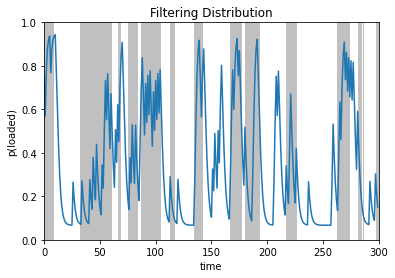

In [14]:
plot_posterior_probs(posterior.filtered_probs, true_states,
                     title="Filtering Distribution")

## Smoothing (forwards-backwards algorithm)

_Smoothing_ means computing the probabilities of the latent state at time $t$ given all emissions, including those that come after. Mathematically, the smoothing distributions are,
\begin{align}
p(z_t \mid y_{1:T}, \theta) &\propto \sum_{z_1} \cdots \sum_{z_{t-1}} \sum_{z_{t+1}} \cdots \sum_{z_T} p(z_{1:T}, y_{1:T} \mid \theta).
\end{align}
The forward-backward algorithm ([Murphy, 2023](https://github.com/probml/pml2-book/releases/tag/2022-10-16); Ch 8.2.4) computes these probabilities for all timesteps $t$ in recursive fashion. 

In code, you can run the forward-backward smoothing algorithm like this.

In [15]:
posterior = hmm.smoother(params, emissions)
print(f"posterior.smoothed_probs.shape: {posterior.smoothed_probs.shape}")

posterior.smoothed_probs.shape: (300, 2)


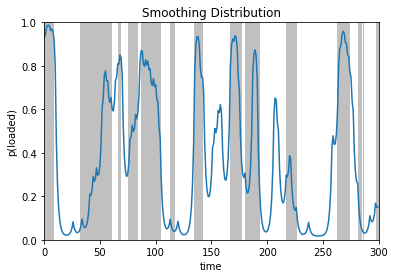

In [16]:
plot_posterior_probs(posterior.smoothed_probs, true_states,
                     title="Smoothing Distribution")

Compare the smoothed probabilities to the filtered ones. See how the sharp rises in probability (e.g. around time step 235) are attenuated in the smoothing distribution? That's because the filtering distribution is sensitive to when the die comes up six, thinking it might indicate a switch to the loaded die. The smoothing distributions benefit from future outcomes, which suggest that the six was just a chance event.

## Most likely state sequence (Viterbi algorithm)

Finally, we can compute the most likely state sequence (aka _maximum a posteriori_ or "MAP" sequence) using the Viterbi algorithm ([Murphy, 2023](https://github.com/probml/pml2-book/releases/tag/2022-10-16); Ch 8.2.7). This dynamic programming algorithm solves for
\begin{align}
z_{1:T}^\star &= \text{arg max}_{z_{1:T}} \; p(z_{1:T}, y_{1:T} \mid \theta).
\end{align}
You can compute the MAP sequence with the following code. 

In [17]:
def plot_map_sequence(most_likely_states, states):
    plt.imshow(states[None, :], extent=(0, num_timesteps, -0.05, 1.05), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.plot(most_likely_states)
    plt.xlabel("time")
    plt.ylabel("MAP state")
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 1])
    plt.title("Viterbi estimate")

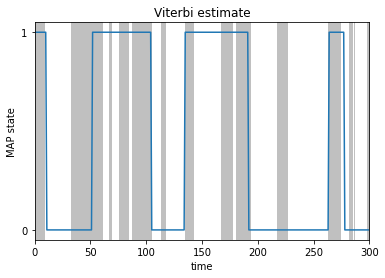

In [18]:
most_likely_states = hmm.most_likely_states(params, emissions)
plot_map_sequence(most_likely_states, true_states)

## Conclusion

This notebook showed how to construct a simple categorical HMM, initialize its parameters, sample data, and use it to perform state inference (i.e. filtering, smoothing, and finding the most likely states). However, often we do not know the model parameters and instead need to estimate them from data. The next notebook shows how to do exactly that.